In [30]:
import pandas as pd
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import transformers
from tensorflow.keras.models import Model
from keras.layers.core import Dense, Dropout
from transformers import TFBertModel,  BertConfig, BertTokenizerFast
import matplotlib.pyplot as plt
import numpy as np

In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

Running on TPU  grpc://10.0.0.2:8470


In [5]:
train = pd.read_csv('../input/dataset-modified/train_modified.csv')
valid = pd.read_csv('../input/dataset-modified/val_modified.csv')
test = pd.read_csv('../input/dataset-modified/test_modified.csv')

xtrain, ytrain = train.Comment.values, train.Emotion.values
xvalid, yvalid = valid.Comment.values, valid.Emotion.values
xtest, ytest = test.Comment.values, test.Emotion.values

In [7]:
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = 'bert-base-multilingual-cased')
max_len = 200

xtrain_pad = tokenizer(
    text=train['Comment'].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

xvalid_pad = tokenizer(
    text=valid['Comment'].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

In [8]:
def build_model(transformer):
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    sequence_output = transformer(input_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(4, activation='softmax')(cls_token)

    model = Model(inputs=input_ids, outputs=out)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(Adam(lr=1e-5, beta_2 = 0.99), loss=loss, metrics=['accuracy'])

    return model

In [22]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

with strategy.scope():
    model_name = 'bert-base-multilingual-cased'
    config = BertConfig.from_pretrained(model_name)
    config.output_hidden_states = False
    transformer_model = TFBertModel.from_pretrained(model_name, config = config)
    model = build_model(transformer_model)
    
model.summary()

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 200)]             0         
_________________________________________________________________
tf_bert_model_1 (TFBertModel ((None, 200, 768), (None, 177853440 
_________________________________________________________________
tf_op_layer_strided_slice_1  [(None, 768)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 3076      
Total params: 177,856,516
Trainable params: 177,856,516
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = model.fit(xtrain_pad['input_ids'], ytrain,epochs=100, validation_data= (xvalid_pad['input_ids'], yvalid), batch_size=64) 

Epoch 1/100
47/47 [==============================] - ETA: 0s - loss: 1.4121 - accuracy: 0.31 - ETA: 2s - loss: 1.4064 - accuracy: 0.27 - ETA: 3s - loss: 1.4105 - accuracy: 0.23 - ETA: 3s - loss: 1.4046 - accuracy: 0.23 - ETA: 3s - loss: 1.4030 - accuracy: 0.22 - ETA: 3s - loss: 1.4009 - accuracy: 0.23 - ETA: 3s - loss: 1.3986 - accuracy: 0.23 - ETA: 3s - loss: 1.3963 - accuracy: 0.24 - ETA: 3s - loss: 1.3954 - accuracy: 0.24 - ETA: 3s - loss: 1.3956 - accuracy: 0.24 - ETA: 3s - loss: 1.3935 - accuracy: 0.25 - ETA: 3s - loss: 1.3922 - accuracy: 0.25 - ETA: 3s - loss: 1.3913 - accuracy: 0.25 - ETA: 3s - loss: 1.3923 - accuracy: 0.25 - ETA: 3s - loss: 1.3922 - accuracy: 0.25 - ETA: 3s - loss: 1.3910 - accuracy: 0.25 - ETA: 3s - loss: 1.3903 - accuracy: 0.25 - ETA: 3s - loss: 1.3895 - accuracy: 0.25 - ETA: 2s - loss: 1.3889 - accuracy: 0.25 - ETA: 2s - loss: 1.3890 - accuracy: 0.25 - ETA: 2s - loss: 1.3888 - accuracy: 0.25 - ETA: 2s - loss: 1.3893 - accuracy: 0.25 - ETA: 2s - loss: 1.3895 

47/47 [==============================] - ETA: 0s - loss: 1.0059 - accuracy: 0.75 - ETA: 2s - loss: 0.9776 - accuracy: 0.77 - ETA: 3s - loss: 0.9593 - accuracy: 0.79 - ETA: 3s - loss: 0.9524 - accuracy: 0.79 - ETA: 3s - loss: 0.9621 - accuracy: 0.78 - ETA: 3s - loss: 0.9621 - accuracy: 0.78 - ETA: 3s - loss: 0.9675 - accuracy: 0.78 - ETA: 3s - loss: 0.9691 - accuracy: 0.77 - ETA: 3s - loss: 0.9658 - accuracy: 0.78 - ETA: 3s - loss: 0.9683 - accuracy: 0.77 - ETA: 3s - loss: 0.9643 - accuracy: 0.78 - ETA: 3s - loss: 0.9593 - accuracy: 0.78 - ETA: 3s - loss: 0.9574 - accuracy: 0.78 - ETA: 3s - loss: 0.9542 - accuracy: 0.79 - ETA: 3s - loss: 0.9490 - accuracy: 0.79 - ETA: 3s - loss: 0.9515 - accuracy: 0.79 - ETA: 3s - loss: 0.9462 - accuracy: 0.79 - ETA: 3s - loss: 0.9485 - accuracy: 0.79 - ETA: 2s - loss: 0.9470 - accuracy: 0.79 - ETA: 2s - loss: 0.9472 - accuracy: 0.79 - ETA: 2s - loss: 0.9502 - accuracy: 0.79 - ETA: 2s - loss: 0.9501 - accuracy: 0.79 - ETA: 2s - loss: 0.9473 - accuracy: 

47/47 [==============================] - ETA: 0s - loss: 0.8601 - accuracy: 0.87 - ETA: 2s - loss: 0.8782 - accuracy: 0.85 - ETA: 3s - loss: 0.8927 - accuracy: 0.84 - ETA: 3s - loss: 0.8814 - accuracy: 0.85 - ETA: 3s - loss: 0.8834 - accuracy: 0.86 - ETA: 3s - loss: 0.8849 - accuracy: 0.85 - ETA: 3s - loss: 0.8912 - accuracy: 0.85 - ETA: 3s - loss: 0.9020 - accuracy: 0.83 - ETA: 3s - loss: 0.8995 - accuracy: 0.84 - ETA: 3s - loss: 0.8953 - accuracy: 0.85 - ETA: 3s - loss: 0.8995 - accuracy: 0.84 - ETA: 3s - loss: 0.8945 - accuracy: 0.85 - ETA: 3s - loss: 0.8959 - accuracy: 0.84 - ETA: 3s - loss: 0.8953 - accuracy: 0.85 - ETA: 3s - loss: 0.8909 - accuracy: 0.85 - ETA: 3s - loss: 0.8867 - accuracy: 0.85 - ETA: 3s - loss: 0.8859 - accuracy: 0.85 - ETA: 3s - loss: 0.8849 - accuracy: 0.86 - ETA: 2s - loss: 0.8895 - accuracy: 0.85 - ETA: 2s - loss: 0.8891 - accuracy: 0.85 - ETA: 2s - loss: 0.8888 - accuracy: 0.85 - ETA: 2s - loss: 0.8901 - accuracy: 0.85 - ETA: 2s - loss: 0.8897 - accuracy: 

47/47 [==============================] - ETA: 0s - loss: 0.8969 - accuracy: 0.84 - ETA: 2s - loss: 0.8758 - accuracy: 0.85 - ETA: 3s - loss: 0.8660 - accuracy: 0.87 - ETA: 3s - loss: 0.8739 - accuracy: 0.86 - ETA: 3s - loss: 0.8647 - accuracy: 0.87 - ETA: 3s - loss: 0.8521 - accuracy: 0.88 - ETA: 3s - loss: 0.8451 - accuracy: 0.89 - ETA: 3s - loss: 0.8464 - accuracy: 0.89 - ETA: 3s - loss: 0.8437 - accuracy: 0.89 - ETA: 3s - loss: 0.8448 - accuracy: 0.89 - ETA: 3s - loss: 0.8478 - accuracy: 0.89 - ETA: 3s - loss: 0.8516 - accuracy: 0.88 - ETA: 3s - loss: 0.8521 - accuracy: 0.88 - ETA: 3s - loss: 0.8500 - accuracy: 0.89 - ETA: 3s - loss: 0.8463 - accuracy: 0.89 - ETA: 3s - loss: 0.8496 - accuracy: 0.89 - ETA: 3s - loss: 0.8496 - accuracy: 0.89 - ETA: 3s - loss: 0.8475 - accuracy: 0.89 - ETA: 2s - loss: 0.8464 - accuracy: 0.89 - ETA: 2s - loss: 0.8454 - accuracy: 0.89 - ETA: 2s - loss: 0.8441 - accuracy: 0.89 - ETA: 2s - loss: 0.8439 - accuracy: 0.89 - ETA: 2s - loss: 0.8466 - accuracy: 

47/47 [==============================] - ETA: 0s - loss: 0.8504 - accuracy: 0.89 - ETA: 2s - loss: 0.8363 - accuracy: 0.91 - ETA: 3s - loss: 0.8263 - accuracy: 0.92 - ETA: 3s - loss: 0.8241 - accuracy: 0.92 - ETA: 3s - loss: 0.8150 - accuracy: 0.93 - ETA: 3s - loss: 0.8094 - accuracy: 0.93 - ETA: 3s - loss: 0.8137 - accuracy: 0.93 - ETA: 4s - loss: 0.8140 - accuracy: 0.93 - ETA: 3s - loss: 0.8097 - accuracy: 0.93 - ETA: 3s - loss: 0.8122 - accuracy: 0.93 - ETA: 3s - loss: 0.8150 - accuracy: 0.93 - ETA: 3s - loss: 0.8184 - accuracy: 0.92 - ETA: 3s - loss: 0.8210 - accuracy: 0.92 - ETA: 3s - loss: 0.8205 - accuracy: 0.92 - ETA: 3s - loss: 0.8197 - accuracy: 0.92 - ETA: 3s - loss: 0.8197 - accuracy: 0.92 - ETA: 3s - loss: 0.8208 - accuracy: 0.92 - ETA: 3s - loss: 0.8217 - accuracy: 0.92 - ETA: 3s - loss: 0.8224 - accuracy: 0.92 - ETA: 2s - loss: 0.8242 - accuracy: 0.92 - ETA: 2s - loss: 0.8220 - accuracy: 0.92 - ETA: 2s - loss: 0.8266 - accuracy: 0.91 - ETA: 2s - loss: 0.8271 - accuracy: 

47/47 [==============================] - ETA: 0s - loss: 0.8117 - accuracy: 0.93 - ETA: 2s - loss: 0.8098 - accuracy: 0.93 - ETA: 3s - loss: 0.8145 - accuracy: 0.93 - ETA: 3s - loss: 0.8241 - accuracy: 0.92 - ETA: 3s - loss: 0.8162 - accuracy: 0.92 - ETA: 3s - loss: 0.8187 - accuracy: 0.92 - ETA: 3s - loss: 0.8114 - accuracy: 0.93 - ETA: 3s - loss: 0.8166 - accuracy: 0.92 - ETA: 3s - loss: 0.8139 - accuracy: 0.93 - ETA: 3s - loss: 0.8145 - accuracy: 0.92 - ETA: 3s - loss: 0.8153 - accuracy: 0.92 - ETA: 3s - loss: 0.8143 - accuracy: 0.92 - ETA: 3s - loss: 0.8107 - accuracy: 0.93 - ETA: 3s - loss: 0.8095 - accuracy: 0.93 - ETA: 3s - loss: 0.8093 - accuracy: 0.93 - ETA: 3s - loss: 0.8096 - accuracy: 0.93 - ETA: 3s - loss: 0.8080 - accuracy: 0.93 - ETA: 3s - loss: 0.8079 - accuracy: 0.93 - ETA: 2s - loss: 0.8098 - accuracy: 0.93 - ETA: 2s - loss: 0.8088 - accuracy: 0.93 - ETA: 2s - loss: 0.8081 - accuracy: 0.93 - ETA: 2s - loss: 0.8115 - accuracy: 0.93 - ETA: 2s - loss: 0.8099 - accuracy: 

47/47 [==============================] - ETA: 0s - loss: 0.8000 - accuracy: 0.93 - ETA: 2s - loss: 0.7954 - accuracy: 0.94 - ETA: 3s - loss: 0.8111 - accuracy: 0.92 - ETA: 3s - loss: 0.8029 - accuracy: 0.93 - ETA: 3s - loss: 0.8105 - accuracy: 0.92 - ETA: 3s - loss: 0.8100 - accuracy: 0.92 - ETA: 3s - loss: 0.8116 - accuracy: 0.92 - ETA: 3s - loss: 0.8112 - accuracy: 0.92 - ETA: 3s - loss: 0.8097 - accuracy: 0.93 - ETA: 3s - loss: 0.8049 - accuracy: 0.93 - ETA: 3s - loss: 0.8057 - accuracy: 0.93 - ETA: 3s - loss: 0.8094 - accuracy: 0.93 - ETA: 3s - loss: 0.8086 - accuracy: 0.93 - ETA: 3s - loss: 0.8064 - accuracy: 0.93 - ETA: 3s - loss: 0.8091 - accuracy: 0.93 - ETA: 3s - loss: 0.8063 - accuracy: 0.93 - ETA: 3s - loss: 0.8053 - accuracy: 0.93 - ETA: 3s - loss: 0.8064 - accuracy: 0.93 - ETA: 2s - loss: 0.8058 - accuracy: 0.93 - ETA: 2s - loss: 0.8059 - accuracy: 0.93 - ETA: 2s - loss: 0.8061 - accuracy: 0.93 - ETA: 2s - loss: 0.8047 - accuracy: 0.93 - ETA: 2s - loss: 0.8033 - accuracy: 

47/47 [==============================] - ETA: 0s - loss: 0.7949 - accuracy: 0.95 - ETA: 2s - loss: 0.8009 - accuracy: 0.94 - ETA: 3s - loss: 0.8269 - accuracy: 0.91 - ETA: 3s - loss: 0.8330 - accuracy: 0.91 - ETA: 3s - loss: 0.8246 - accuracy: 0.91 - ETA: 3s - loss: 0.8206 - accuracy: 0.92 - ETA: 3s - loss: 0.8195 - accuracy: 0.92 - ETA: 3s - loss: 0.8158 - accuracy: 0.92 - ETA: 3s - loss: 0.8125 - accuracy: 0.93 - ETA: 3s - loss: 0.8093 - accuracy: 0.93 - ETA: 3s - loss: 0.8077 - accuracy: 0.93 - ETA: 3s - loss: 0.8034 - accuracy: 0.94 - ETA: 3s - loss: 0.8036 - accuracy: 0.93 - ETA: 3s - loss: 0.8027 - accuracy: 0.94 - ETA: 3s - loss: 0.8030 - accuracy: 0.94 - ETA: 3s - loss: 0.8024 - accuracy: 0.94 - ETA: 3s - loss: 0.8014 - accuracy: 0.94 - ETA: 3s - loss: 0.8025 - accuracy: 0.94 - ETA: 2s - loss: 0.8023 - accuracy: 0.94 - ETA: 2s - loss: 0.8027 - accuracy: 0.94 - ETA: 2s - loss: 0.8058 - accuracy: 0.93 - ETA: 2s - loss: 0.8045 - accuracy: 0.93 - ETA: 2s - loss: 0.8056 - accuracy: 

47/47 [==============================] - ETA: 0s - loss: 0.7756 - accuracy: 0.96 - ETA: 2s - loss: 0.7925 - accuracy: 0.95 - ETA: 3s - loss: 0.7890 - accuracy: 0.95 - ETA: 3s - loss: 0.7854 - accuracy: 0.96 - ETA: 3s - loss: 0.7878 - accuracy: 0.95 - ETA: 3s - loss: 0.7878 - accuracy: 0.95 - ETA: 3s - loss: 0.7893 - accuracy: 0.95 - ETA: 3s - loss: 0.7867 - accuracy: 0.95 - ETA: 3s - loss: 0.7920 - accuracy: 0.95 - ETA: 3s - loss: 0.7965 - accuracy: 0.94 - ETA: 3s - loss: 0.7974 - accuracy: 0.94 - ETA: 3s - loss: 0.7970 - accuracy: 0.94 - ETA: 3s - loss: 0.7995 - accuracy: 0.94 - ETA: 3s - loss: 0.7978 - accuracy: 0.94 - ETA: 3s - loss: 0.7966 - accuracy: 0.94 - ETA: 3s - loss: 0.7936 - accuracy: 0.95 - ETA: 3s - loss: 0.7950 - accuracy: 0.94 - ETA: 3s - loss: 0.7953 - accuracy: 0.94 - ETA: 2s - loss: 0.7983 - accuracy: 0.94 - ETA: 2s - loss: 0.7979 - accuracy: 0.94 - ETA: 2s - loss: 0.7966 - accuracy: 0.94 - ETA: 2s - loss: 0.7984 - accuracy: 0.94 - ETA: 2s - loss: 0.7988 - accuracy: 

47/47 [==============================] - ETA: 0s - loss: 0.8074 - accuracy: 0.93 - ETA: 2s - loss: 0.7986 - accuracy: 0.94 - ETA: 3s - loss: 0.8006 - accuracy: 0.94 - ETA: 3s - loss: 0.7985 - accuracy: 0.94 - ETA: 3s - loss: 0.7938 - accuracy: 0.95 - ETA: 3s - loss: 0.7880 - accuracy: 0.95 - ETA: 3s - loss: 0.7863 - accuracy: 0.95 - ETA: 3s - loss: 0.7868 - accuracy: 0.95 - ETA: 3s - loss: 0.7870 - accuracy: 0.95 - ETA: 3s - loss: 0.7856 - accuracy: 0.95 - ETA: 3s - loss: 0.7902 - accuracy: 0.95 - ETA: 3s - loss: 0.7880 - accuracy: 0.95 - ETA: 3s - loss: 0.7883 - accuracy: 0.95 - ETA: 3s - loss: 0.7870 - accuracy: 0.95 - ETA: 3s - loss: 0.7868 - accuracy: 0.95 - ETA: 3s - loss: 0.7852 - accuracy: 0.95 - ETA: 3s - loss: 0.7898 - accuracy: 0.95 - ETA: 3s - loss: 0.7907 - accuracy: 0.95 - ETA: 2s - loss: 0.7923 - accuracy: 0.95 - ETA: 2s - loss: 0.7915 - accuracy: 0.95 - ETA: 2s - loss: 0.7922 - accuracy: 0.95 - ETA: 2s - loss: 0.7908 - accuracy: 0.95 - ETA: 2s - loss: 0.7926 - accuracy: 

47/47 [==============================] - ETA: 0s - loss: 0.8238 - accuracy: 0.92 - ETA: 2s - loss: 0.8305 - accuracy: 0.91 - ETA: 4s - loss: 0.8140 - accuracy: 0.93 - ETA: 4s - loss: 0.8159 - accuracy: 0.92 - ETA: 4s - loss: 0.8245 - accuracy: 0.92 - ETA: 4s - loss: 0.8189 - accuracy: 0.92 - ETA: 4s - loss: 0.8173 - accuracy: 0.92 - ETA: 4s - loss: 0.8213 - accuracy: 0.92 - ETA: 4s - loss: 0.8223 - accuracy: 0.92 - ETA: 3s - loss: 0.8204 - accuracy: 0.92 - ETA: 3s - loss: 0.8198 - accuracy: 0.92 - ETA: 3s - loss: 0.8174 - accuracy: 0.92 - ETA: 3s - loss: 0.8144 - accuracy: 0.92 - ETA: 3s - loss: 0.8133 - accuracy: 0.92 - ETA: 3s - loss: 0.8145 - accuracy: 0.92 - ETA: 3s - loss: 0.8162 - accuracy: 0.92 - ETA: 3s - loss: 0.8147 - accuracy: 0.92 - ETA: 3s - loss: 0.8169 - accuracy: 0.92 - ETA: 3s - loss: 0.8171 - accuracy: 0.92 - ETA: 2s - loss: 0.8155 - accuracy: 0.92 - ETA: 2s - loss: 0.8148 - accuracy: 0.92 - ETA: 2s - loss: 0.8131 - accuracy: 0.92 - ETA: 2s - loss: 0.8108 - accuracy: 

47/47 [==============================] - ETA: 0s - loss: 0.7893 - accuracy: 0.95 - ETA: 2s - loss: 0.8207 - accuracy: 0.92 - ETA: 3s - loss: 0.8000 - accuracy: 0.94 - ETA: 3s - loss: 0.8024 - accuracy: 0.94 - ETA: 3s - loss: 0.7969 - accuracy: 0.94 - ETA: 3s - loss: 0.7959 - accuracy: 0.94 - ETA: 3s - loss: 0.7906 - accuracy: 0.95 - ETA: 3s - loss: 0.7988 - accuracy: 0.94 - ETA: 3s - loss: 0.7996 - accuracy: 0.94 - ETA: 3s - loss: 0.7978 - accuracy: 0.94 - ETA: 3s - loss: 0.7943 - accuracy: 0.94 - ETA: 3s - loss: 0.7940 - accuracy: 0.94 - ETA: 3s - loss: 0.7906 - accuracy: 0.95 - ETA: 3s - loss: 0.7941 - accuracy: 0.94 - ETA: 3s - loss: 0.7943 - accuracy: 0.95 - ETA: 3s - loss: 0.7974 - accuracy: 0.94 - ETA: 3s - loss: 0.7970 - accuracy: 0.94 - ETA: 3s - loss: 0.7969 - accuracy: 0.94 - ETA: 2s - loss: 0.7990 - accuracy: 0.94 - ETA: 2s - loss: 0.7971 - accuracy: 0.94 - ETA: 2s - loss: 0.7953 - accuracy: 0.94 - ETA: 2s - loss: 0.7952 - accuracy: 0.94 - ETA: 2s - loss: 0.7957 - accuracy: 

47/47 [==============================] - ETA: 0s - loss: 0.7750 - accuracy: 0.96 - ETA: 2s - loss: 0.7740 - accuracy: 0.96 - ETA: 3s - loss: 0.7848 - accuracy: 0.95 - ETA: 3s - loss: 0.7863 - accuracy: 0.95 - ETA: 3s - loss: 0.7843 - accuracy: 0.95 - ETA: 3s - loss: 0.7906 - accuracy: 0.95 - ETA: 3s - loss: 0.7928 - accuracy: 0.95 - ETA: 3s - loss: 0.8003 - accuracy: 0.94 - ETA: 3s - loss: 0.8007 - accuracy: 0.94 - ETA: 3s - loss: 0.8043 - accuracy: 0.93 - ETA: 3s - loss: 0.8046 - accuracy: 0.93 - ETA: 3s - loss: 0.8021 - accuracy: 0.94 - ETA: 3s - loss: 0.8000 - accuracy: 0.94 - ETA: 3s - loss: 0.8005 - accuracy: 0.94 - ETA: 3s - loss: 0.8008 - accuracy: 0.94 - ETA: 3s - loss: 0.7972 - accuracy: 0.94 - ETA: 3s - loss: 0.7949 - accuracy: 0.94 - ETA: 3s - loss: 0.7965 - accuracy: 0.94 - ETA: 2s - loss: 0.7970 - accuracy: 0.94 - ETA: 2s - loss: 0.7951 - accuracy: 0.94 - ETA: 2s - loss: 0.7963 - accuracy: 0.94 - ETA: 2s - loss: 0.7954 - accuracy: 0.94 - ETA: 2s - loss: 0.7946 - accuracy: 

47/47 [==============================] - ETA: 0s - loss: 0.7982 - accuracy: 0.93 - ETA: 2s - loss: 0.7944 - accuracy: 0.94 - ETA: 3s - loss: 0.8036 - accuracy: 0.93 - ETA: 3s - loss: 0.7886 - accuracy: 0.95 - ETA: 3s - loss: 0.7883 - accuracy: 0.95 - ETA: 3s - loss: 0.7927 - accuracy: 0.95 - ETA: 3s - loss: 0.7943 - accuracy: 0.94 - ETA: 3s - loss: 0.7997 - accuracy: 0.94 - ETA: 3s - loss: 0.7970 - accuracy: 0.94 - ETA: 3s - loss: 0.7978 - accuracy: 0.94 - ETA: 3s - loss: 0.8001 - accuracy: 0.94 - ETA: 3s - loss: 0.8021 - accuracy: 0.94 - ETA: 3s - loss: 0.8018 - accuracy: 0.94 - ETA: 3s - loss: 0.7999 - accuracy: 0.94 - ETA: 3s - loss: 0.7983 - accuracy: 0.94 - ETA: 3s - loss: 0.7987 - accuracy: 0.94 - ETA: 3s - loss: 0.7955 - accuracy: 0.94 - ETA: 3s - loss: 0.7953 - accuracy: 0.94 - ETA: 3s - loss: 0.7942 - accuracy: 0.94 - ETA: 2s - loss: 0.7940 - accuracy: 0.94 - ETA: 2s - loss: 0.7928 - accuracy: 0.95 - ETA: 2s - loss: 0.7916 - accuracy: 0.95 - ETA: 2s - loss: 0.7923 - accuracy: 

47/47 [==============================] - ETA: 0s - loss: 0.7920 - accuracy: 0.95 - ETA: 2s - loss: 0.8153 - accuracy: 0.92 - ETA: 3s - loss: 0.8019 - accuracy: 0.94 - ETA: 3s - loss: 0.8017 - accuracy: 0.94 - ETA: 3s - loss: 0.7976 - accuracy: 0.94 - ETA: 3s - loss: 0.7937 - accuracy: 0.95 - ETA: 3s - loss: 0.7958 - accuracy: 0.94 - ETA: 3s - loss: 0.7952 - accuracy: 0.94 - ETA: 3s - loss: 0.7929 - accuracy: 0.94 - ETA: 3s - loss: 0.7927 - accuracy: 0.95 - ETA: 3s - loss: 0.7933 - accuracy: 0.94 - ETA: 3s - loss: 0.7917 - accuracy: 0.95 - ETA: 3s - loss: 0.7942 - accuracy: 0.94 - ETA: 3s - loss: 0.7991 - accuracy: 0.94 - ETA: 3s - loss: 0.7964 - accuracy: 0.94 - ETA: 3s - loss: 0.7971 - accuracy: 0.94 - ETA: 3s - loss: 0.7976 - accuracy: 0.94 - ETA: 3s - loss: 0.7981 - accuracy: 0.94 - ETA: 2s - loss: 0.7977 - accuracy: 0.94 - ETA: 2s - loss: 0.7976 - accuracy: 0.94 - ETA: 2s - loss: 0.7960 - accuracy: 0.94 - ETA: 2s - loss: 0.7946 - accuracy: 0.94 - ETA: 2s - loss: 0.7930 - accuracy: 

47/47 [==============================] - ETA: 0s - loss: 0.7453 - accuracy: 1.00 - ETA: 2s - loss: 0.7681 - accuracy: 0.97 - ETA: 3s - loss: 0.7860 - accuracy: 0.95 - ETA: 3s - loss: 0.7755 - accuracy: 0.96 - ETA: 3s - loss: 0.7725 - accuracy: 0.97 - ETA: 3s - loss: 0.7731 - accuracy: 0.97 - ETA: 3s - loss: 0.7779 - accuracy: 0.96 - ETA: 3s - loss: 0.7834 - accuracy: 0.96 - ETA: 3s - loss: 0.7826 - accuracy: 0.96 - ETA: 3s - loss: 0.7812 - accuracy: 0.96 - ETA: 3s - loss: 0.7819 - accuracy: 0.96 - ETA: 3s - loss: 0.7827 - accuracy: 0.96 - ETA: 3s - loss: 0.7857 - accuracy: 0.95 - ETA: 3s - loss: 0.7846 - accuracy: 0.95 - ETA: 3s - loss: 0.7860 - accuracy: 0.95 - ETA: 3s - loss: 0.7855 - accuracy: 0.95 - ETA: 3s - loss: 0.7876 - accuracy: 0.95 - ETA: 3s - loss: 0.7878 - accuracy: 0.95 - ETA: 2s - loss: 0.7875 - accuracy: 0.95 - ETA: 2s - loss: 0.7867 - accuracy: 0.95 - ETA: 2s - loss: 0.7861 - accuracy: 0.95 - ETA: 2s - loss: 0.7863 - accuracy: 0.95 - ETA: 2s - loss: 0.7851 - accuracy: 

47/47 [==============================] - ETA: 0s - loss: 0.7631 - accuracy: 0.98 - ETA: 2s - loss: 0.8172 - accuracy: 0.92 - ETA: 3s - loss: 0.8110 - accuracy: 0.92 - ETA: 3s - loss: 0.8038 - accuracy: 0.93 - ETA: 3s - loss: 0.8043 - accuracy: 0.93 - ETA: 3s - loss: 0.7987 - accuracy: 0.94 - ETA: 3s - loss: 0.8043 - accuracy: 0.93 - ETA: 3s - loss: 0.7968 - accuracy: 0.94 - ETA: 3s - loss: 0.7943 - accuracy: 0.94 - ETA: 3s - loss: 0.7908 - accuracy: 0.95 - ETA: 3s - loss: 0.7893 - accuracy: 0.95 - ETA: 3s - loss: 0.7896 - accuracy: 0.95 - ETA: 3s - loss: 0.7864 - accuracy: 0.95 - ETA: 3s - loss: 0.7847 - accuracy: 0.95 - ETA: 3s - loss: 0.7831 - accuracy: 0.95 - ETA: 3s - loss: 0.7850 - accuracy: 0.95 - ETA: 3s - loss: 0.7843 - accuracy: 0.95 - ETA: 3s - loss: 0.7848 - accuracy: 0.95 - ETA: 2s - loss: 0.7876 - accuracy: 0.95 - ETA: 2s - loss: 0.7862 - accuracy: 0.95 - ETA: 2s - loss: 0.7871 - accuracy: 0.95 - ETA: 2s - loss: 0.7859 - accuracy: 0.95 - ETA: 2s - loss: 0.7881 - accuracy: 

47/47 [==============================] - ETA: 0s - loss: 0.7594 - accuracy: 0.98 - ETA: 2s - loss: 0.7893 - accuracy: 0.95 - ETA: 3s - loss: 0.7793 - accuracy: 0.96 - ETA: 3s - loss: 0.7821 - accuracy: 0.96 - ETA: 3s - loss: 0.7784 - accuracy: 0.96 - ETA: 3s - loss: 0.7778 - accuracy: 0.96 - ETA: 3s - loss: 0.7775 - accuracy: 0.96 - ETA: 3s - loss: 0.7813 - accuracy: 0.96 - ETA: 3s - loss: 0.7840 - accuracy: 0.96 - ETA: 3s - loss: 0.7831 - accuracy: 0.96 - ETA: 3s - loss: 0.7810 - accuracy: 0.96 - ETA: 3s - loss: 0.7780 - accuracy: 0.96 - ETA: 3s - loss: 0.7765 - accuracy: 0.96 - ETA: 3s - loss: 0.7753 - accuracy: 0.96 - ETA: 3s - loss: 0.7769 - accuracy: 0.96 - ETA: 3s - loss: 0.7768 - accuracy: 0.96 - ETA: 3s - loss: 0.7758 - accuracy: 0.96 - ETA: 3s - loss: 0.7774 - accuracy: 0.96 - ETA: 2s - loss: 0.7757 - accuracy: 0.96 - ETA: 2s - loss: 0.7756 - accuracy: 0.96 - ETA: 2s - loss: 0.7750 - accuracy: 0.96 - ETA: 2s - loss: 0.7753 - accuracy: 0.96 - ETA: 2s - loss: 0.7766 - accuracy: 

47/47 [==============================] - ETA: 0s - loss: 0.7913 - accuracy: 0.95 - ETA: 2s - loss: 0.7753 - accuracy: 0.96 - ETA: 3s - loss: 0.7798 - accuracy: 0.96 - ETA: 3s - loss: 0.7754 - accuracy: 0.96 - ETA: 3s - loss: 0.7753 - accuracy: 0.96 - ETA: 3s - loss: 0.7803 - accuracy: 0.96 - ETA: 3s - loss: 0.7840 - accuracy: 0.95 - ETA: 3s - loss: 0.7809 - accuracy: 0.96 - ETA: 3s - loss: 0.7834 - accuracy: 0.96 - ETA: 3s - loss: 0.7842 - accuracy: 0.95 - ETA: 3s - loss: 0.7847 - accuracy: 0.95 - ETA: 3s - loss: 0.7826 - accuracy: 0.96 - ETA: 3s - loss: 0.7855 - accuracy: 0.95 - ETA: 3s - loss: 0.7859 - accuracy: 0.95 - ETA: 3s - loss: 0.7843 - accuracy: 0.95 - ETA: 3s - loss: 0.7837 - accuracy: 0.96 - ETA: 3s - loss: 0.7823 - accuracy: 0.96 - ETA: 3s - loss: 0.7819 - accuracy: 0.96 - ETA: 2s - loss: 0.7807 - accuracy: 0.96 - ETA: 2s - loss: 0.7820 - accuracy: 0.96 - ETA: 2s - loss: 0.7802 - accuracy: 0.96 - ETA: 2s - loss: 0.7814 - accuracy: 0.96 - ETA: 2s - loss: 0.7826 - accuracy: 

47/47 [==============================] - ETA: 0s - loss: 0.8218 - accuracy: 0.92 - ETA: 2s - loss: 0.7984 - accuracy: 0.94 - ETA: 3s - loss: 0.7955 - accuracy: 0.94 - ETA: 3s - loss: 0.7865 - accuracy: 0.95 - ETA: 3s - loss: 0.7811 - accuracy: 0.96 - ETA: 3s - loss: 0.7780 - accuracy: 0.96 - ETA: 3s - loss: 0.7776 - accuracy: 0.96 - ETA: 3s - loss: 0.7753 - accuracy: 0.96 - ETA: 3s - loss: 0.7735 - accuracy: 0.97 - ETA: 3s - loss: 0.7799 - accuracy: 0.96 - ETA: 3s - loss: 0.7805 - accuracy: 0.96 - ETA: 3s - loss: 0.7813 - accuracy: 0.96 - ETA: 3s - loss: 0.7808 - accuracy: 0.96 - ETA: 3s - loss: 0.7837 - accuracy: 0.95 - ETA: 3s - loss: 0.7866 - accuracy: 0.95 - ETA: 3s - loss: 0.7879 - accuracy: 0.95 - ETA: 3s - loss: 0.7875 - accuracy: 0.95 - ETA: 3s - loss: 0.7885 - accuracy: 0.95 - ETA: 2s - loss: 0.7875 - accuracy: 0.95 - ETA: 2s - loss: 0.7860 - accuracy: 0.95 - ETA: 2s - loss: 0.7851 - accuracy: 0.95 - ETA: 2s - loss: 0.7833 - accuracy: 0.96 - ETA: 2s - loss: 0.7829 - accuracy: 

47/47 [==============================] - ETA: 0s - loss: 0.7749 - accuracy: 0.96 - ETA: 2s - loss: 0.7827 - accuracy: 0.96 - ETA: 3s - loss: 0.7709 - accuracy: 0.97 - ETA: 3s - loss: 0.7717 - accuracy: 0.97 - ETA: 3s - loss: 0.7754 - accuracy: 0.96 - ETA: 3s - loss: 0.7701 - accuracy: 0.97 - ETA: 3s - loss: 0.7730 - accuracy: 0.97 - ETA: 3s - loss: 0.7752 - accuracy: 0.96 - ETA: 3s - loss: 0.7786 - accuracy: 0.96 - ETA: 3s - loss: 0.7751 - accuracy: 0.96 - ETA: 3s - loss: 0.7737 - accuracy: 0.97 - ETA: 3s - loss: 0.7738 - accuracy: 0.97 - ETA: 3s - loss: 0.7751 - accuracy: 0.96 - ETA: 3s - loss: 0.7728 - accuracy: 0.97 - ETA: 3s - loss: 0.7719 - accuracy: 0.97 - ETA: 3s - loss: 0.7741 - accuracy: 0.96 - ETA: 3s - loss: 0.7732 - accuracy: 0.97 - ETA: 3s - loss: 0.7750 - accuracy: 0.96 - ETA: 2s - loss: 0.7742 - accuracy: 0.96 - ETA: 2s - loss: 0.7742 - accuracy: 0.96 - ETA: 2s - loss: 0.7757 - accuracy: 0.96 - ETA: 2s - loss: 0.7750 - accuracy: 0.96 - ETA: 2s - loss: 0.7743 - accuracy: 

47/47 [==============================] - ETA: 0s - loss: 0.7593 - accuracy: 0.98 - ETA: 2s - loss: 0.7673 - accuracy: 0.97 - ETA: 3s - loss: 0.7855 - accuracy: 0.95 - ETA: 3s - loss: 0.7789 - accuracy: 0.96 - ETA: 3s - loss: 0.7719 - accuracy: 0.97 - ETA: 3s - loss: 0.7698 - accuracy: 0.97 - ETA: 3s - loss: 0.7772 - accuracy: 0.96 - ETA: 3s - loss: 0.7750 - accuracy: 0.96 - ETA: 3s - loss: 0.7765 - accuracy: 0.96 - ETA: 3s - loss: 0.7779 - accuracy: 0.96 - ETA: 3s - loss: 0.7780 - accuracy: 0.96 - ETA: 3s - loss: 0.7764 - accuracy: 0.96 - ETA: 3s - loss: 0.7787 - accuracy: 0.96 - ETA: 3s - loss: 0.7762 - accuracy: 0.96 - ETA: 3s - loss: 0.7763 - accuracy: 0.96 - ETA: 3s - loss: 0.7773 - accuracy: 0.96 - ETA: 3s - loss: 0.7780 - accuracy: 0.96 - ETA: 3s - loss: 0.7787 - accuracy: 0.96 - ETA: 2s - loss: 0.7802 - accuracy: 0.96 - ETA: 2s - loss: 0.7831 - accuracy: 0.96 - ETA: 2s - loss: 0.7820 - accuracy: 0.96 - ETA: 2s - loss: 0.7804 - accuracy: 0.96 - ETA: 2s - loss: 0.7808 - accuracy: 

47/47 [==============================] - ETA: 0s - loss: 0.8050 - accuracy: 0.93 - ETA: 2s - loss: 0.7881 - accuracy: 0.95 - ETA: 3s - loss: 0.7782 - accuracy: 0.96 - ETA: 3s - loss: 0.7773 - accuracy: 0.96 - ETA: 3s - loss: 0.7768 - accuracy: 0.96 - ETA: 3s - loss: 0.7791 - accuracy: 0.96 - ETA: 3s - loss: 0.7807 - accuracy: 0.96 - ETA: 3s - loss: 0.7857 - accuracy: 0.95 - ETA: 3s - loss: 0.7827 - accuracy: 0.96 - ETA: 3s - loss: 0.7831 - accuracy: 0.95 - ETA: 3s - loss: 0.7810 - accuracy: 0.96 - ETA: 3s - loss: 0.7779 - accuracy: 0.96 - ETA: 3s - loss: 0.7789 - accuracy: 0.96 - ETA: 3s - loss: 0.7786 - accuracy: 0.96 - ETA: 3s - loss: 0.7814 - accuracy: 0.96 - ETA: 3s - loss: 0.7820 - accuracy: 0.96 - ETA: 3s - loss: 0.7816 - accuracy: 0.96 - ETA: 3s - loss: 0.7838 - accuracy: 0.95 - ETA: 2s - loss: 0.7834 - accuracy: 0.95 - ETA: 2s - loss: 0.7822 - accuracy: 0.96 - ETA: 2s - loss: 0.7833 - accuracy: 0.95 - ETA: 2s - loss: 0.7816 - accuracy: 0.96 - ETA: 2s - loss: 0.7806 - accuracy: 

47/47 [==============================] - ETA: 0s - loss: 0.7594 - accuracy: 0.98 - ETA: 2s - loss: 0.7749 - accuracy: 0.96 - ETA: 3s - loss: 0.7797 - accuracy: 0.96 - ETA: 3s - loss: 0.7732 - accuracy: 0.96 - ETA: 3s - loss: 0.7724 - accuracy: 0.96 - ETA: 3s - loss: 0.7676 - accuracy: 0.97 - ETA: 3s - loss: 0.7711 - accuracy: 0.97 - ETA: 3s - loss: 0.7716 - accuracy: 0.97 - ETA: 3s - loss: 0.7702 - accuracy: 0.97 - ETA: 3s - loss: 0.7707 - accuracy: 0.97 - ETA: 3s - loss: 0.7767 - accuracy: 0.96 - ETA: 3s - loss: 0.7752 - accuracy: 0.96 - ETA: 3s - loss: 0.7740 - accuracy: 0.96 - ETA: 3s - loss: 0.7752 - accuracy: 0.96 - ETA: 3s - loss: 0.7752 - accuracy: 0.96 - ETA: 3s - loss: 0.7742 - accuracy: 0.96 - ETA: 3s - loss: 0.7761 - accuracy: 0.96 - ETA: 3s - loss: 0.7762 - accuracy: 0.96 - ETA: 2s - loss: 0.7770 - accuracy: 0.96 - ETA: 2s - loss: 0.7791 - accuracy: 0.96 - ETA: 2s - loss: 0.7789 - accuracy: 0.96 - ETA: 2s - loss: 0.7781 - accuracy: 0.96 - ETA: 2s - loss: 0.7773 - accuracy: 

47/47 [==============================] - ETA: 0s - loss: 0.7906 - accuracy: 0.95 - ETA: 2s - loss: 0.7690 - accuracy: 0.97 - ETA: 3s - loss: 0.7710 - accuracy: 0.97 - ETA: 3s - loss: 0.7759 - accuracy: 0.96 - ETA: 3s - loss: 0.7732 - accuracy: 0.97 - ETA: 3s - loss: 0.7735 - accuracy: 0.97 - ETA: 3s - loss: 0.7715 - accuracy: 0.97 - ETA: 3s - loss: 0.7719 - accuracy: 0.97 - ETA: 3s - loss: 0.7727 - accuracy: 0.97 - ETA: 3s - loss: 0.7776 - accuracy: 0.96 - ETA: 3s - loss: 0.7774 - accuracy: 0.96 - ETA: 3s - loss: 0.7809 - accuracy: 0.96 - ETA: 3s - loss: 0.7817 - accuracy: 0.96 - ETA: 3s - loss: 0.7814 - accuracy: 0.96 - ETA: 3s - loss: 0.7831 - accuracy: 0.96 - ETA: 3s - loss: 0.7845 - accuracy: 0.96 - ETA: 3s - loss: 0.7839 - accuracy: 0.96 - ETA: 3s - loss: 0.7851 - accuracy: 0.95 - ETA: 2s - loss: 0.7854 - accuracy: 0.95 - ETA: 2s - loss: 0.7872 - accuracy: 0.95 - ETA: 2s - loss: 0.7859 - accuracy: 0.95 - ETA: 2s - loss: 0.7861 - accuracy: 0.95 - ETA: 2s - loss: 0.7849 - accuracy: 

47/47 [==============================] - ETA: 0s - loss: 0.7437 - accuracy: 1.00 - ETA: 2s - loss: 0.7437 - accuracy: 1.00 - ETA: 3s - loss: 0.7489 - accuracy: 0.99 - ETA: 3s - loss: 0.7593 - accuracy: 0.98 - ETA: 3s - loss: 0.7656 - accuracy: 0.97 - ETA: 3s - loss: 0.7671 - accuracy: 0.97 - ETA: 3s - loss: 0.7660 - accuracy: 0.97 - ETA: 3s - loss: 0.7671 - accuracy: 0.97 - ETA: 3s - loss: 0.7645 - accuracy: 0.97 - ETA: 3s - loss: 0.7693 - accuracy: 0.97 - ETA: 3s - loss: 0.7731 - accuracy: 0.97 - ETA: 3s - loss: 0.7733 - accuracy: 0.97 - ETA: 3s - loss: 0.7758 - accuracy: 0.96 - ETA: 3s - loss: 0.7791 - accuracy: 0.96 - ETA: 3s - loss: 0.7809 - accuracy: 0.96 - ETA: 3s - loss: 0.7823 - accuracy: 0.96 - ETA: 3s - loss: 0.7827 - accuracy: 0.96 - ETA: 3s - loss: 0.7814 - accuracy: 0.96 - ETA: 2s - loss: 0.7811 - accuracy: 0.96 - ETA: 2s - loss: 0.7816 - accuracy: 0.96 - ETA: 2s - loss: 0.7805 - accuracy: 0.96 - ETA: 2s - loss: 0.7798 - accuracy: 0.96 - ETA: 2s - loss: 0.7796 - accuracy: 

47/47 [==============================] - ETA: 0s - loss: 0.7905 - accuracy: 0.95 - ETA: 2s - loss: 0.7833 - accuracy: 0.96 - ETA: 3s - loss: 0.7753 - accuracy: 0.96 - ETA: 3s - loss: 0.7752 - accuracy: 0.96 - ETA: 3s - loss: 0.7720 - accuracy: 0.97 - ETA: 3s - loss: 0.7700 - accuracy: 0.97 - ETA: 3s - loss: 0.7707 - accuracy: 0.97 - ETA: 3s - loss: 0.7712 - accuracy: 0.97 - ETA: 3s - loss: 0.7699 - accuracy: 0.97 - ETA: 3s - loss: 0.7762 - accuracy: 0.96 - ETA: 3s - loss: 0.7761 - accuracy: 0.96 - ETA: 3s - loss: 0.7747 - accuracy: 0.96 - ETA: 3s - loss: 0.7723 - accuracy: 0.97 - ETA: 3s - loss: 0.7776 - accuracy: 0.96 - ETA: 3s - loss: 0.7754 - accuracy: 0.96 - ETA: 3s - loss: 0.7734 - accuracy: 0.96 - ETA: 3s - loss: 0.7744 - accuracy: 0.96 - ETA: 3s - loss: 0.7727 - accuracy: 0.97 - ETA: 2s - loss: 0.7728 - accuracy: 0.97 - ETA: 2s - loss: 0.7737 - accuracy: 0.96 - ETA: 2s - loss: 0.7752 - accuracy: 0.96 - ETA: 2s - loss: 0.7752 - accuracy: 0.96 - ETA: 2s - loss: 0.7747 - accuracy: 

47/47 [==============================] - ETA: 0s - loss: 0.7905 - accuracy: 0.95 - ETA: 2s - loss: 0.8062 - accuracy: 0.93 - ETA: 3s - loss: 0.7853 - accuracy: 0.95 - ETA: 3s - loss: 0.7827 - accuracy: 0.96 - ETA: 3s - loss: 0.7749 - accuracy: 0.96 - ETA: 3s - loss: 0.7724 - accuracy: 0.97 - ETA: 4s - loss: 0.7750 - accuracy: 0.96 - ETA: 4s - loss: 0.7808 - accuracy: 0.96 - ETA: 4s - loss: 0.7802 - accuracy: 0.96 - ETA: 4s - loss: 0.7765 - accuracy: 0.96 - ETA: 4s - loss: 0.7750 - accuracy: 0.96 - ETA: 3s - loss: 0.7749 - accuracy: 0.96 - ETA: 3s - loss: 0.7749 - accuracy: 0.96 - ETA: 3s - loss: 0.7726 - accuracy: 0.97 - ETA: 3s - loss: 0.7717 - accuracy: 0.97 - ETA: 3s - loss: 0.7709 - accuracy: 0.97 - ETA: 3s - loss: 0.7702 - accuracy: 0.97 - ETA: 3s - loss: 0.7689 - accuracy: 0.97 - ETA: 3s - loss: 0.7686 - accuracy: 0.97 - ETA: 3s - loss: 0.7673 - accuracy: 0.97 - ETA: 2s - loss: 0.7699 - accuracy: 0.97 - ETA: 2s - loss: 0.7694 - accuracy: 0.97 - ETA: 2s - loss: 0.7697 - accuracy: 

47/47 [==============================] - ETA: 0s - loss: 0.7749 - accuracy: 0.96 - ETA: 2s - loss: 0.7671 - accuracy: 0.97 - ETA: 3s - loss: 0.7645 - accuracy: 0.97 - ETA: 3s - loss: 0.7710 - accuracy: 0.97 - ETA: 3s - loss: 0.7780 - accuracy: 0.96 - ETA: 3s - loss: 0.7734 - accuracy: 0.97 - ETA: 3s - loss: 0.7691 - accuracy: 0.97 - ETA: 3s - loss: 0.7660 - accuracy: 0.97 - ETA: 3s - loss: 0.7687 - accuracy: 0.97 - ETA: 3s - loss: 0.7678 - accuracy: 0.97 - ETA: 3s - loss: 0.7713 - accuracy: 0.97 - ETA: 3s - loss: 0.7771 - accuracy: 0.96 - ETA: 3s - loss: 0.7792 - accuracy: 0.96 - ETA: 3s - loss: 0.7789 - accuracy: 0.96 - ETA: 3s - loss: 0.7792 - accuracy: 0.96 - ETA: 3s - loss: 0.7780 - accuracy: 0.96 - ETA: 3s - loss: 0.7784 - accuracy: 0.96 - ETA: 3s - loss: 0.7773 - accuracy: 0.96 - ETA: 2s - loss: 0.7764 - accuracy: 0.96 - ETA: 2s - loss: 0.7785 - accuracy: 0.96 - ETA: 2s - loss: 0.7776 - accuracy: 0.96 - ETA: 2s - loss: 0.7775 - accuracy: 0.96 - ETA: 2s - loss: 0.7774 - accuracy: 

47/47 [==============================] - ETA: 0s - loss: 0.7749 - accuracy: 0.96 - ETA: 2s - loss: 0.7594 - accuracy: 0.98 - ETA: 3s - loss: 0.7646 - accuracy: 0.97 - ETA: 3s - loss: 0.7633 - accuracy: 0.98 - ETA: 3s - loss: 0.7593 - accuracy: 0.98 - ETA: 3s - loss: 0.7671 - accuracy: 0.97 - ETA: 3s - loss: 0.7705 - accuracy: 0.97 - ETA: 3s - loss: 0.7710 - accuracy: 0.97 - ETA: 3s - loss: 0.7715 - accuracy: 0.97 - ETA: 3s - loss: 0.7718 - accuracy: 0.97 - ETA: 3s - loss: 0.7693 - accuracy: 0.97 - ETA: 3s - loss: 0.7710 - accuracy: 0.97 - ETA: 3s - loss: 0.7713 - accuracy: 0.97 - ETA: 3s - loss: 0.7739 - accuracy: 0.96 - ETA: 3s - loss: 0.7741 - accuracy: 0.96 - ETA: 3s - loss: 0.7732 - accuracy: 0.97 - ETA: 3s - loss: 0.7715 - accuracy: 0.97 - ETA: 3s - loss: 0.7709 - accuracy: 0.97 - ETA: 2s - loss: 0.7711 - accuracy: 0.97 - ETA: 2s - loss: 0.7697 - accuracy: 0.97 - ETA: 2s - loss: 0.7700 - accuracy: 0.97 - ETA: 2s - loss: 0.7695 - accuracy: 0.97 - ETA: 2s - loss: 0.7697 - accuracy: 

47/47 [==============================] - ETA: 0s - loss: 0.7649 - accuracy: 0.98 - ETA: 2s - loss: 0.7621 - accuracy: 0.98 - ETA: 3s - loss: 0.7820 - accuracy: 0.96 - ETA: 3s - loss: 0.7920 - accuracy: 0.95 - ETA: 3s - loss: 0.7886 - accuracy: 0.95 - ETA: 3s - loss: 0.7837 - accuracy: 0.96 - ETA: 3s - loss: 0.7818 - accuracy: 0.96 - ETA: 3s - loss: 0.7790 - accuracy: 0.96 - ETA: 3s - loss: 0.7768 - accuracy: 0.96 - ETA: 3s - loss: 0.7775 - accuracy: 0.96 - ETA: 3s - loss: 0.7744 - accuracy: 0.96 - ETA: 3s - loss: 0.7744 - accuracy: 0.96 - ETA: 3s - loss: 0.7745 - accuracy: 0.96 - ETA: 3s - loss: 0.7756 - accuracy: 0.96 - ETA: 3s - loss: 0.7745 - accuracy: 0.96 - ETA: 3s - loss: 0.7743 - accuracy: 0.96 - ETA: 3s - loss: 0.7743 - accuracy: 0.96 - ETA: 3s - loss: 0.7747 - accuracy: 0.96 - ETA: 2s - loss: 0.7738 - accuracy: 0.96 - ETA: 2s - loss: 0.7747 - accuracy: 0.96 - ETA: 2s - loss: 0.7740 - accuracy: 0.96 - ETA: 2s - loss: 0.7740 - accuracy: 0.96 - ETA: 2s - loss: 0.7740 - accuracy: 

47/47 [==============================] - ETA: 0s - loss: 0.7906 - accuracy: 0.95 - ETA: 2s - loss: 0.7749 - accuracy: 0.96 - ETA: 3s - loss: 0.7749 - accuracy: 0.96 - ETA: 3s - loss: 0.7787 - accuracy: 0.96 - ETA: 3s - loss: 0.7779 - accuracy: 0.96 - ETA: 3s - loss: 0.7748 - accuracy: 0.96 - ETA: 3s - loss: 0.7770 - accuracy: 0.96 - ETA: 3s - loss: 0.7768 - accuracy: 0.96 - ETA: 3s - loss: 0.7764 - accuracy: 0.96 - ETA: 3s - loss: 0.7762 - accuracy: 0.96 - ETA: 3s - loss: 0.7775 - accuracy: 0.96 - ETA: 3s - loss: 0.7773 - accuracy: 0.96 - ETA: 3s - loss: 0.7773 - accuracy: 0.96 - ETA: 3s - loss: 0.7760 - accuracy: 0.96 - ETA: 3s - loss: 0.7738 - accuracy: 0.96 - ETA: 3s - loss: 0.7757 - accuracy: 0.96 - ETA: 3s - loss: 0.7747 - accuracy: 0.96 - ETA: 3s - loss: 0.7773 - accuracy: 0.96 - ETA: 2s - loss: 0.7788 - accuracy: 0.96 - ETA: 2s - loss: 0.7779 - accuracy: 0.96 - ETA: 2s - loss: 0.7778 - accuracy: 0.96 - ETA: 2s - loss: 0.7777 - accuracy: 0.96 - ETA: 2s - loss: 0.7789 - accuracy: 

47/47 [==============================] - ETA: 0s - loss: 0.7591 - accuracy: 0.98 - ETA: 2s - loss: 0.7826 - accuracy: 0.96 - ETA: 3s - loss: 0.7696 - accuracy: 0.97 - ETA: 3s - loss: 0.7671 - accuracy: 0.97 - ETA: 3s - loss: 0.7655 - accuracy: 0.97 - ETA: 3s - loss: 0.7645 - accuracy: 0.97 - ETA: 4s - loss: 0.7660 - accuracy: 0.97 - ETA: 4s - loss: 0.7691 - accuracy: 0.97 - ETA: 4s - loss: 0.7680 - accuracy: 0.97 - ETA: 4s - loss: 0.7687 - accuracy: 0.97 - ETA: 3s - loss: 0.7664 - accuracy: 0.97 - ETA: 3s - loss: 0.7683 - accuracy: 0.97 - ETA: 3s - loss: 0.7676 - accuracy: 0.97 - ETA: 3s - loss: 0.7703 - accuracy: 0.97 - ETA: 3s - loss: 0.7706 - accuracy: 0.97 - ETA: 3s - loss: 0.7719 - accuracy: 0.97 - ETA: 3s - loss: 0.7721 - accuracy: 0.97 - ETA: 3s - loss: 0.7706 - accuracy: 0.97 - ETA: 3s - loss: 0.7700 - accuracy: 0.97 - ETA: 2s - loss: 0.7687 - accuracy: 0.97 - ETA: 2s - loss: 0.7690 - accuracy: 0.97 - ETA: 2s - loss: 0.7693 - accuracy: 0.97 - ETA: 2s - loss: 0.7682 - accuracy: 

47/47 [==============================] - ETA: 0s - loss: 0.7749 - accuracy: 0.96 - ETA: 2s - loss: 0.7810 - accuracy: 0.96 - ETA: 3s - loss: 0.7790 - accuracy: 0.96 - ETA: 3s - loss: 0.7858 - accuracy: 0.95 - ETA: 3s - loss: 0.7805 - accuracy: 0.96 - ETA: 3s - loss: 0.7796 - accuracy: 0.96 - ETA: 3s - loss: 0.7771 - accuracy: 0.96 - ETA: 3s - loss: 0.7749 - accuracy: 0.96 - ETA: 3s - loss: 0.7749 - accuracy: 0.96 - ETA: 3s - loss: 0.7794 - accuracy: 0.96 - ETA: 3s - loss: 0.7804 - accuracy: 0.96 - ETA: 3s - loss: 0.7787 - accuracy: 0.96 - ETA: 3s - loss: 0.7772 - accuracy: 0.96 - ETA: 3s - loss: 0.7748 - accuracy: 0.96 - ETA: 3s - loss: 0.7748 - accuracy: 0.96 - ETA: 3s - loss: 0.7739 - accuracy: 0.96 - ETA: 3s - loss: 0.7736 - accuracy: 0.96 - ETA: 3s - loss: 0.7737 - accuracy: 0.96 - ETA: 2s - loss: 0.7754 - accuracy: 0.96 - ETA: 2s - loss: 0.7738 - accuracy: 0.96 - ETA: 2s - loss: 0.7731 - accuracy: 0.97 - ETA: 2s - loss: 0.7725 - accuracy: 0.97 - ETA: 2s - loss: 0.7733 - accuracy: 

In [24]:
def plot_learning_curve(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    plt.plot(loss, label='loss')
    plt.plot(val_loss,label='val loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['loss','val_loss'],loc='upper right')
    plt.show()
 
    
    plt.plot(accuracy, label='accuracy')
    plt.plot(val_accuracy,label='val accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['accuracy','val accuracy'],loc='upper right')
    plt.show()
    


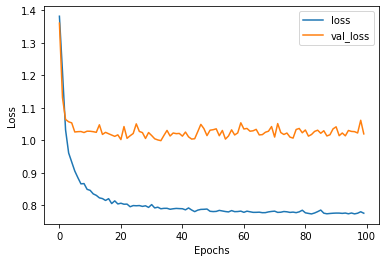

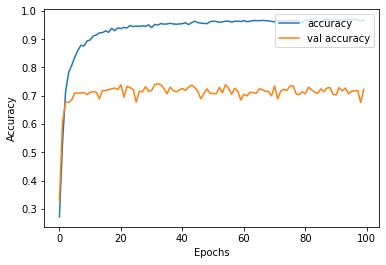

In [25]:
plot_learning_curve(history)

In [26]:
test_x = tokenizer(
    text=test['Comment'].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

model_eval = model.evaluate(
    x={'input_ids': test_x['input_ids']},
    y=ytest
)

21/21 [==============================] - ETA: 0s - loss: 1.1186 - accuracy: 0.62 - ETA: 0s - loss: 1.0968 - accuracy: 0.63 - ETA: 0s - loss: 1.0709 - accuracy: 0.66 - ETA: 0s - loss: 1.0668 - accuracy: 0.66 - ETA: 0s - loss: 1.0706 - accuracy: 0.66 - ETA: 0s - loss: 1.0756 - accuracy: 0.66 - ETA: 0s - loss: 1.0881 - accuracy: 0.65 - ETA: 0s - loss: 1.0766 - accuracy: 0.66 - ETA: 0s - loss: 1.0772 - accuracy: 0.66 - ETA: 0s - loss: 1.0594 - accuracy: 0.68 - ETA: 0s - loss: 1.0691 - accuracy: 0.67 - 7s 312ms/step - loss: 1.0691 - accuracy: 0.6719


In [29]:
model_eval

[1.0690524578094482, 0.6718506813049316]

In [27]:
def prediction(model,tokenizer,input_string):
    
    padded_tokens = tokenizer(
    text=[input_string],
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)
    
    prediction = model.predict(padded_tokens['input_ids'])
    print(prediction)
    conversion_dict = {0:'joy',1:'fear',2:'anger',3:'sadness'}
    
    return conversion_dict[np.argmax(prediction)]

In [32]:
# I am overjoyed
prediction(model, tokenizer, 'நான் மிகவும் மகிழ்ச்சியடைகிறேன்')

[[9.9908483e-01 4.3162791e-07 2.0289334e-04 7.1169680e-04]]


'joy'

In [33]:
# i am very annoyed at you
prediction(model, tokenizer, 'sono molto seccato con te')

[[5.7090281e-05 1.2285926e-07 9.9989355e-01 4.9196969e-05]]


'anger'

In [34]:
#someone is staring at me
prediction(model, tokenizer, "quelqu'un me regarde")

[[0.04581049 0.6035639  0.34990832 0.00071727]]


'fear'

In [35]:
# I very sad
prediction(model, tokenizer, 'मै बहुत दुखी हूँ')

[[0.04581049 0.6035639  0.34990832 0.7071727]]

'sadness'
